In [200]:
import os
import pathlib
import re

import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from astroquery.gaia import Gaia
Gaia.login(credentials_file=os.path.expanduser('~/.gaia/archive.login'))

OK


Assuming you ran `scripts/download`, you have the SB9public directory in your `$datadir`...so you might need to adjust some paths below!

In [201]:
data_dir = pathlib.Path('/Users/apricewhelan/data/Binaries/')

In [202]:
sb9_tblname = 'sb9_2021_02'
sb9_archive_tblname = f'user_{username}.{sb9_tblname}'
username = Gaia._TapPlus__user

In [203]:
# see: !head -n 20 SB9public/ReadMe.txt
colnames = [
    'id',
    'j1900_str',
    'j2000_str',
    'component',
    'mag1', 'filter1',
    'mag2', 'filter2',
    'spt1', 'spt2'
]

sb9_tbl = at.Table.read(data_dir / 'SB9public/Main.dta',
                        delimiter='|', format='ascii.basic',
                        names=colnames)

# only keep sources with magnitudes in SB9 (this removes ~90 sources)
sb9_tbl = sb9_tbl[~sb9_tbl['mag1'].mask]

# also remove whack values - this removes another 2 sources
mag_mask = np.ones(len(sb9_tbl), dtype=bool)
for i, m in enumerate(sb9_tbl['mag1']):
    try:
        float(m)
        mag_mask[i] = False
    except:
        pass
sb9_tbl = sb9_tbl[~mag_mask]
sb9_tbl['mag1'] = sb9_tbl['mag1'].filled(np.nan).astype(float)
sb9_tbl['mag2'] = sb9_tbl['mag2'].filled(1e5)  # MAGIC NUMBER

Cool I love parsing string coordinates

In [146]:
pattr = re.compile('([0-9]{2})([0-9]{2})([0-9]{2})([0-9]{1,})([\+\-])([0-9]{2})([0-9]{2})([0-9]{2})([0-9]{0,})')
ra = []
dec = []
for str_c in sb9_tbl['j2000_str']:
    (ra_h, ra_m, ra_s, ra_s2, 
     dec_sign, dec_d, dec_m, dec_s, dec_s2) = pattr.search(str_c).groups()
    
    ra_hms = float(ra_h) + float(ra_m)/60 + float(f"{ra_s}.{ra_s2}")/3600
    dec_dms = float(dec_d) + float(dec_m)/60 + float(f"{dec_s}.{dec_s2}")/3600
    dec_dms = float(f'{dec_sign}1') * dec_dms
    
    ra.append(ra_hms * u.hourangle)
    dec.append(dec_dms * u.degree)

# simply validation by passing in to lon/lat classes:
ra = coord.Longitude(ra)
dec = coord.Latitude(dec)

sb9_tbl['ra_deg'] = ra.degree
sb9_tbl['dec_deg'] = dec.degree

In [148]:
tblnames = [t.name for t in Gaia.load_tables(only_names=True)]

if sb9_archive_tblname not in tblnames:
    job = Gaia.upload_table(sb9_tbl['id', 'ra_deg', 'dec_deg'], 
                            table_name=sb9_tblname)

INFO: Retrieving tables... [astroquery.utils.tap.core]
INFO: Parsing tables... [astroquery.utils.tap.core]
INFO: Done. [astroquery.utils.tap.core]
Sending pytable.
Uploaded table 'sb9_2021_02'.


For subqueries, we can't use a wildcard to get all column names, so we explicitly have to ask for all gaia columns...

In [149]:
gaia_tbl = Gaia.load_table('gaiaedr3.gaia_source')
all_gaia_columns = [f"subq.{c.name}" for c in gaia_tbl.columns]

Retrieving table 'gaiaedr3.gaia_source'
Parsing table 'gaiaedr3.gaia_source'...
Done.


In [150]:
init_tol = 30 * u.arcsec
final_tol = 4 * u.arcsec
sb9_epoch = 2000.  # This is a guess!
 
q = f"""
SELECT subq.id, {', '.join(all_gaia_columns)}
FROM (
    SELECT sb9.id, sb9.ra_deg, sb9.dec_deg, gaia.*
    FROM {sb9_archive_tblname} AS sb9, gaiaedr3.gaia_source as gaia
    WHERE 
        contains(POINT('ICRS', sb9.ra_deg, sb9.dec_deg),
                 CIRCLE('ICRS', gaia.ra, gaia.dec, {init_tol.to_value(u.deg)}))=1
    OFFSET 0
) AS subq
WHERE 
    contains(POINT('ICRS', subq.ra + subq.pmra / 3600e3  * ({sb9_epoch} - subq.ref_epoch) / COS(RADIANS(subq.dec)), 
                           subq.dec + subq.pmdec / 3600e3 * ({sb9_epoch} - subq.ref_epoch)),
             CIRCLE('ICRS', subq.ra_deg, subq.dec_deg, {final_tol.to_value(u.deg)}))=1
"""

In [151]:
job = Gaia.launch_job_async(q, name='sb9-edr3')

INFO: Query finished. [astroquery.utils.tap.core]


In [152]:
xm_tbl = job.get_results()

In [164]:
joined = at.join(sb9_tbl, xm_tbl, keys='id')

(-5.0, 5.0)

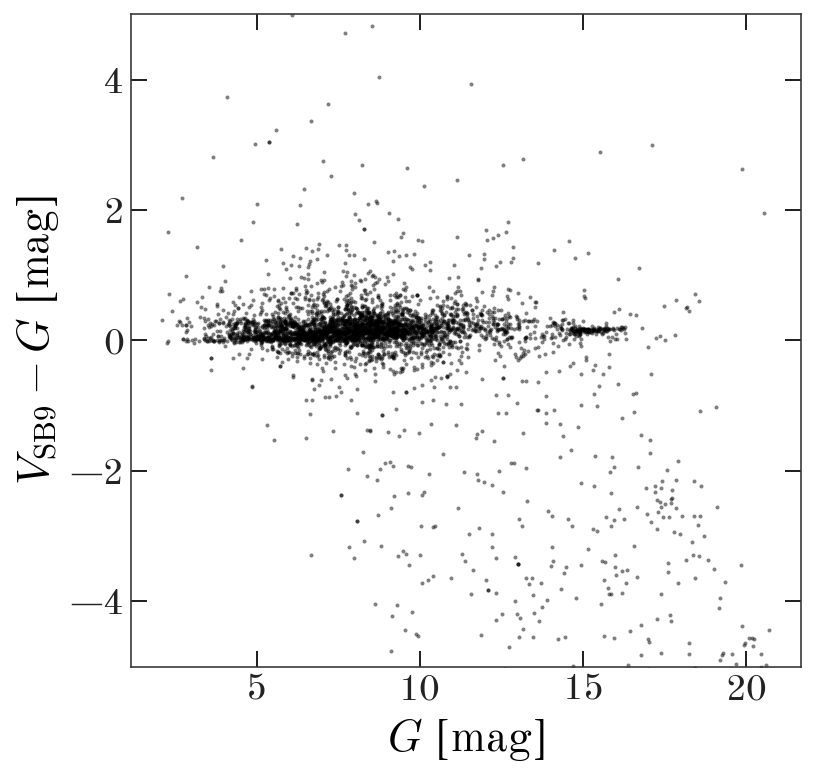

In [181]:
mag = -np.log10((10**-joined['mag1'] + 10**-joined['mag2']))

plt.figure(figsize=(6, 6))
plt.scatter(joined['phot_g_mean_mag'], mag - joined['phot_g_mean_mag'],
            alpha=0.5, lw=0, s=4)
plt.xlabel('$G$ [mag]')
plt.ylabel(r'$V_{\rm SB9} - G$ [mag]')
plt.ylim(-5, 5)

OK so there are definitely sources with unexpected Gaia mags given the V-band mags in SB9, so we can trim those as (hopefully) duplicate / spurious matches. We could do something much better here, since there is a color-dependent transform between G <--> V...but, ya'know, hacks:

In [189]:
dmag = mag - joined['phot_g_mean_mag']

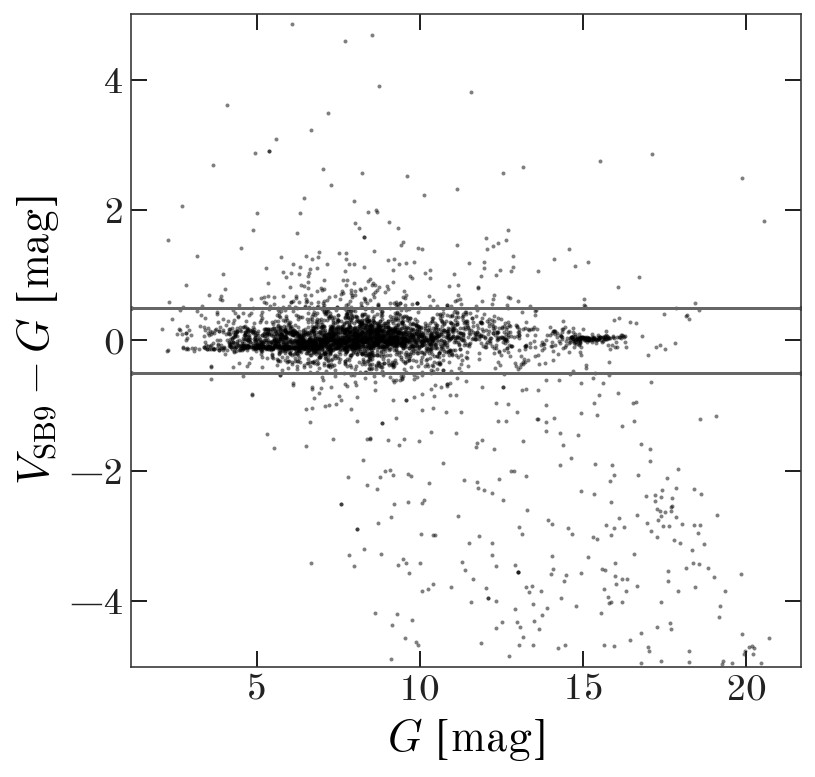

In [191]:
dmag_cut = 0.5

plt.figure(figsize=(6, 6))
plt.scatter(joined['phot_g_mean_mag'], 
            dmag - np.median(dmag),
            alpha=0.5, lw=0, s=4)
plt.xlabel('$G$ [mag]')
plt.ylabel(r'$V_{\rm SB9} - G$ [mag]')
plt.ylim(-5, 5)
plt.axhline(dmag_cut)
plt.axhline(-dmag_cut)

In [192]:
joined_dmag = joined[np.abs(dmag - np.median(dmag)) < dmag_cut]

In [193]:
_, counts = np.unique(joined_dmag['id'], return_counts=True)
(counts > 1).sum()

9

OK so there are only a few duplicates remaining...I think we can just ignore them? You're still left with ~3200 binaries!

In [204]:
len(joined_dmag)

3252

You can then join to the `Orbits.dta` file:

Columns in Orbits.dta:
```
     1            System number
     2            Orbit number for that system
     3            Period (d)
     4            error on P (d)
     5            Periastron time (JD-2400000)
     6            error on Periastron time
     7            Flag on periastron time
     8            eccentricity
     9            error on eccentricity
    10            argument of periastron (deg)
    11            error on omega
    12            K1 (km/s)
    13            error on K1 (km/s)    
    14            K2 (km/s)
    15            error on K2 (km/s)
    16            systemic velocity (km/s)
    17            error on V0 (km/s)
    18            rms RV1 (km/s)
    19            rms RV2 (km/s)
    20            #RV1
    21            #RV2
    22            Grade (0:poor, 5: definitive)
    23            Bibcode
    24            Contributor
    25            Accessibility
    26            Reference adopted for the times (JD or MJD)
```